# Transfer learning and fine-tuning
- https://www.tensorflow.org/tutorials/images/transfer_learning
- pre-trained model 활용법: 1) 그 자체로 쓰거나 2) transfer learning

이번 노트북에서는 두 가지 케이스로 써볼 것 
1. feature extraction
2. fine-tuning

순서
1. Examine and understand the data
2. Build an input pipeline
3. Compose the model
    - Load in the pretrained base model (and pretrained weights)
    - Stack the classification layers on top
4. Train the model
5. Evaluate model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) # origin -> local 저장
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered') # path_to_zip기 속한 dir 안에 'cats...' 생성

68608000/68606236 [==============================] - 8s 0us/step


In [21]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
# train_dir 하위디렉토리를 폴더로 인식
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


(32, 160, 160, 3)


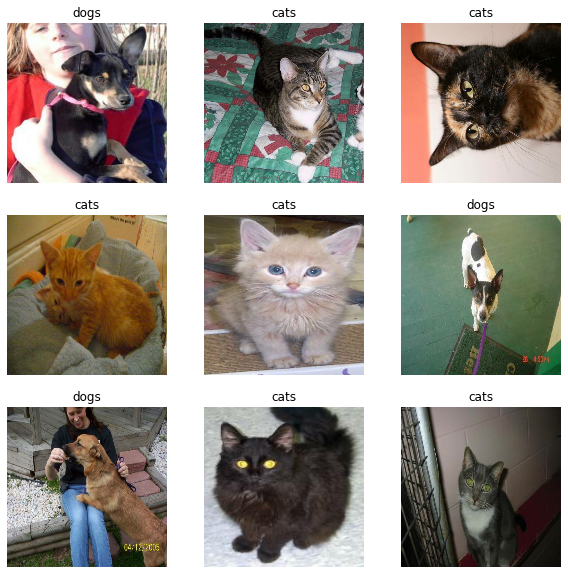

In [18]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    print(images.shape)  # train_dataset - 한 배치당 32개 데이터 포함 (batch_size=32)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [22]:
# 이 데이터는 train, validation으로 나눠져 있음 -> test dataset도 만들어보자 (validation dataset에서 일부 추출)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)  # skip: take와 정반대의 기능

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

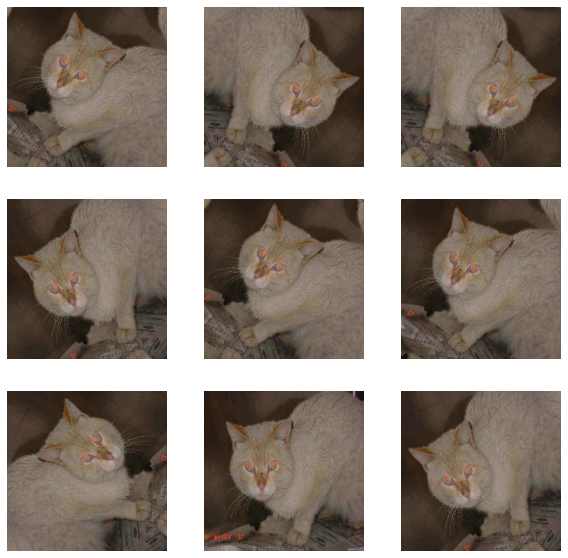

In [26]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) # 매번 랜덤
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input  # base model
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)  # base model input [-1, 1]이어야 하므로

MobileNet V2 
- 구글에서 ImageNet 데이터 기반으로 만든 모델
- 활용방법
    1. top layer를 새로 만들고 학습시키는 방법
    2. 특정 layer까지는 그대로 쓰고 그 이후만 새로 학습시키는 방법 

In [39]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # top layer(분류층)를 제외한 층 -> bottleneck layer
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [40]:
image_batch, label_batch = next(iter(train_dataset)) # 배치 하나씩 꺼내줌 
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)
# 160, 160, 3 -> 5, 5, 1280 

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [41]:
# freeze model
base_model.trainable = False

### tf.keras.layers.BatchNormalization layers 관련 주의사항
- layer.trainable = False 하는 경우 -> BatchNormalization layer는 inference 모드이므로 
- 즉, mean/variance가 학습데이터 기준임
- 다른건 freezing하더라도 BatchNormalization 레이어는 학습하도록 해야 함 
- 참고: https://www.tensorflow.org/guide/keras/transfer_learning


In [42]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [46]:
# add classification (5x5 펼쳐주고 -> dense layer)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()  # avg pooling 전략
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
print(prediction_layer(feature_batch_average).shape)

(32, 1280)
(32, 1)


In [47]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs) # Sequential 대신인듯 

In [48]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), # 그냥 adam 쓰는 대신 learning rate 조절하기 위함
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary() # base 모델 내부가 다 안나오네 (Sequential이 아닌 model로 하니)
# trainable vs. non-traininable params가 둘 다 나옴

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [50]:
len(model.trainable_variables)

2

In [51]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 10s 316ms/step - loss: 0.9514 - accuracy: 0.5007


In [52]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 33s 485ms/step - loss: 0.7834 - accuracy: 0.5415 - val_loss: 0.5967 - val_accuracy: 0.6399
Epoch 2/10
63/63 [==============================] - 31s 479ms/step - loss: 0.5638 - accuracy: 0.6860 - val_loss: 0.4416 - val_accuracy: 0.7450
Epoch 3/10
63/63 [==============================] - 32s 500ms/step - loss: 0.4621 - accuracy: 0.7585 - val_loss: 0.3398 - val_accuracy: 0.8193
Epoch 4/10
63/63 [==============================] - 35s 545ms/step - loss: 0.3827 - accuracy: 0.8185 - val_loss: 0.2733 - val_accuracy: 0.8762
Epoch 5/10
63/63 [==============================] - 31s 479ms/step - loss: 0.3518 - accuracy: 0.8375 - val_loss: 0.2326 - val_accuracy: 0.8911
Epoch 6/10
63/63 [==============================] - 33s 512ms/step - loss: 0.3057 - accuracy: 0.8545 - val_loss: 0.2010 - val_accuracy: 0.9183
Epoch 7/10
63/63 [==============================] - 33s 510ms/step - loss: 0.2768 - accuracy: 0.8775 - val_loss: 0.1809 - val_accuracy: 0.9257

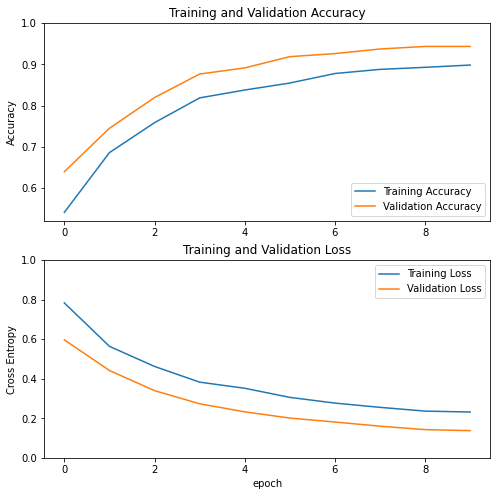

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

train이 validation보다 안 좋은 이유 - dropout (batchnormalization도 있다는데 이건 왜 이유가 되는지 모르겠음)
- dropout은 오버피팅 막기 위해 일부 데이터를 0으로 변환함 -> 학습 단계에서만 동작하고 validation일때는 꺼져있음

In [54]:
# base model의 일부 layer만 재학습 
base_model.trainable = True
print(len(base_model.layers))

154


In [55]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False # 나머지 54개만 학습 

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [58]:
model.summary() # 아까 모델 그대로 쓰되, base model의 trainable만 바꿈 (compile의 optimizer도.. )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [59]:
len(model.trainable_variables) # 2였는데 바뀜 

56

In [60]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], # epochs과 차이가 뭐지?
                         validation_data=validation_dataset)

# model 구조 그대로 (initial_epochs으로 학습) -> base_model의 trainable을 일부 변경 (추가 학습)
# -> fine_tune_epochs 추가하고 아까 epochs부터 학습을 다시 함 

Epoch 10/20
63/63 [==============================] - 41s 645ms/step - loss: 0.0956 - accuracy: 0.9605 - val_loss: 0.0657 - val_accuracy: 0.9728
Epoch 11/20
18/63 [=======>......................] - ETA: 21s - loss: 0.1025 - accuracy: 0.9618

In [ ]:
acc += history_fine.history['accuracy'] # 왜 더할까..?
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")